# Import Libraries

In [1]:
import os
import sys
import warnings
import pandas
import numpy
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
import string
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")
%matplotlib inline

# Load Dataset

In [2]:
df = pd.read_csv("Stress.csv")

In [3]:
df.head()

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.8,1521614353
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.0,1527009817
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.8,1535935605
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.6,1516429555
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.8,1539809005


In [4]:
df.tail()

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
2833,relationships,7oee1t,"[35, 40]","* Her, a week ago: Precious, how are you? (I i...",0,1.000000,1515187044
2834,ptsd,9p4ung,"[20, 25]",I don't have the ability to cope with it anymo...,1,1.000000,1539827412
2835,anxiety,9nam6l,"(5, 10)",In case this is the first time you're reading ...,0,1.000000,1539269312
2836,almosthomeless,5y53ya,"[5, 10]",Do you find this normal? They have a good rela...,0,0.571429,1488938143
2837,ptsd,5y25cl,"[0, 5]",I was talking to my mom this morning and she s...,1,0.571429,1488909516


In [5]:
df.columns

Index(['subreddit', 'post_id', 'sentence_range', 'text', 'label', 'confidence',
       'social_timestamp'],
      dtype='object')

In [6]:
df.shape

(2838, 7)

In [7]:
df.isnull().sum()

subreddit           0
post_id             0
sentence_range      0
text                0
label               0
confidence          0
social_timestamp    0
dtype: int64

In [8]:
df.duplicated().sum()

0

# Clean Data for Text Column

In [9]:
nltk.download('stopwords')
stemmer = nltk.SnowballStemmer("english")
stopword=set(stopwords.words('english'))
def clean(text):                                       # function for cleaning the text column             
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text
df["text"] = df["text"].apply(clean)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\avina\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## WordCloud

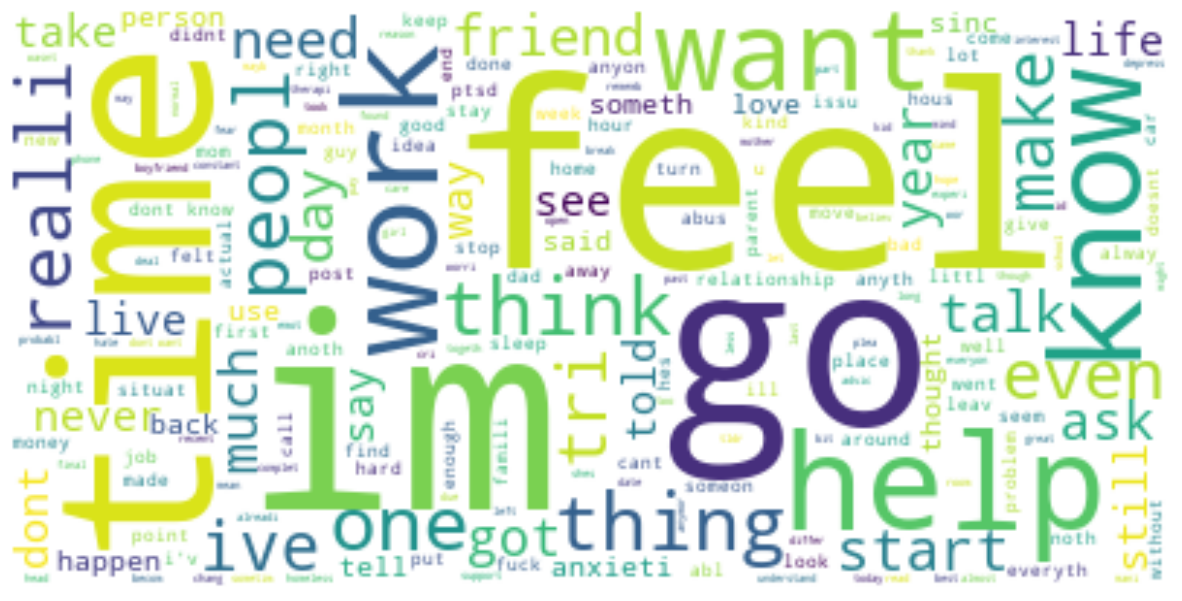

In [10]:
text = " ".join(i for i in df.text)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, 
                      background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [11]:
df["new_label"] = df["label"].map({0: "No Stress", 1: "Stress"})
df = df[["text", "new_label"]]
print(df.head())

                                                text  new_label
0  said felt way sugget go rest trigger ahead you...     Stress
1  hey rassist sure right place post goe  im curr...  No Stress
2  mom hit newspap shock would know dont like pla...     Stress
3  met new boyfriend amaz kind sweet good student...     Stress
4  octob domest violenc awar month domest violenc...     Stress


## Spliting Dataset 

In [12]:
x = np.array(df["text"])
y = np.array(df["new_label"])
cv = CountVectorizer()
X = cv.fit_transform(x)
xtrain, xtest, ytrain, ytest = train_test_split(X, y, 
                                                test_size=0.33, 
                                                random_state=42)

# Model Building

## Naive Bayes

In [13]:
from sklearn.naive_bayes import BernoulliNB
model_1 = BernoulliNB()
model_1.fit(xtrain,ytrain)

BernoulliNB()

In [14]:
ypred = model_1.predict(xtest)

In [15]:
print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

   No Stress       0.79      0.64      0.70       444
      Stress       0.72      0.85      0.78       493

    accuracy                           0.75       937
   macro avg       0.75      0.74      0.74       937
weighted avg       0.75      0.75      0.74       937



In [16]:
model_2 = MultinomialNB()
model_2.fit(xtrain,ytrain)
print(classification_report(ytest,model_2.predict(xtest)))

              precision    recall  f1-score   support

   No Stress       0.81      0.61      0.69       444
      Stress       0.71      0.87      0.78       493

    accuracy                           0.74       937
   macro avg       0.76      0.74      0.74       937
weighted avg       0.76      0.74      0.74       937



In [17]:
ytrain= LabelEncoder().fit_transform(ytrain) 
ytest=  LabelEncoder().fit_transform(ytest)

## XGBOOST

In [18]:
model_3 = XGBClassifier()
model_3.fit(xtrain,ytrain)
print(classification_report(ytest,model_3.predict(xtest)))

              precision    recall  f1-score   support

           0       0.72      0.70      0.71       444
           1       0.73      0.76      0.75       493

    accuracy                           0.73       937
   macro avg       0.73      0.73      0.73       937
weighted avg       0.73      0.73      0.73       937



## Random Forest

In [19]:
model_4 = RandomForestClassifier(n_estimators=10, criterion='entropy')
model_4.fit(xtrain,ytrain)

RandomForestClassifier(criterion='entropy', n_estimators=10)

In [20]:
ypred = model_4.predict(xtest)

In [21]:
print(classification_report(ytest,ypred))

              precision    recall  f1-score   support

           0       0.64      0.64      0.64       444
           1       0.67      0.67      0.67       493

    accuracy                           0.66       937
   macro avg       0.65      0.65      0.65       937
weighted avg       0.66      0.66      0.66       937



# Model Evaluation

In [22]:
user = input("Text: ")
df = cv.transform([user]).toarray()
output = model_1.predict(df)
print(output)

Text: I am fine.
['No Stress']


In [23]:
ser = input("Text: ")
df = cv.transform([user]).toarray()
output = model_2.predict(df)
print(output)

Text: I am depress.
['Stress']


# Conclusion:
   ### Bernoulli Naive Bayes perform well overall with accuracy of 75%.

# Thank you!